# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import pickle
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from skimage.filters import rank
import glob
import os
%matplotlib inline

In [2]:
training_file = './data/train.p'
validation_file='./data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [3]:
n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Validation Set:", len(X_validation))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Validation Set: 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [4]:
def show_images(images,labels):
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        index = random.randint(0, len(images))
        plt.imshow(images[index])
        plt.xlabel(labels[index])
    plt.show()

In [5]:
def show_gray_images(images,labels):
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        index = random.randint(0, len(images))
        plt.imshow(images[index],cmap='gray')
        plt.xlabel(labels[index])
    plt.show()

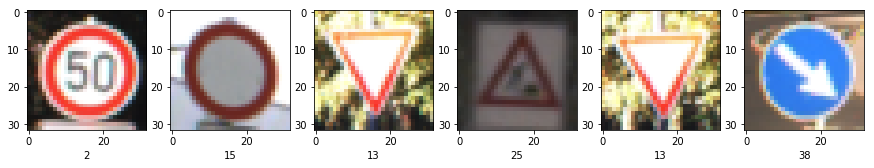

In [6]:
show_images(X_train,y_train)

Image contrast seems to be low for lot of images

### Histogram of the count of images in each unique class

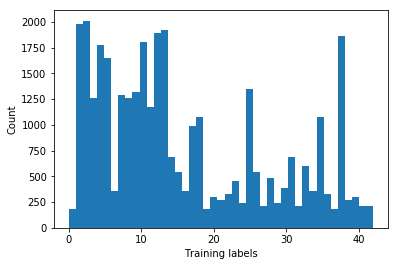

In [7]:
plt.hist(y_train,43)
plt.xlabel('Training labels')
plt.ylabel('Count')
plt.show()

I find some class bias issue as some classes seem to be underrepresented

----
## Step 2: Pre-process the Data Set

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. However, dividing by 255 gave me a better accuracy.

I conducted a few preprocessing steps to the input images to achieve a better accuracy:

1. Shuffling:

In [8]:
X_train, y_train = shuffle(X_train, y_train)

2. Grayscalling:

In [9]:
def gray_scale(image):
    grey=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return grey

3. Normalization:

In [10]:
# Just dividing works better than (pixels-128)/128
def normalize_image(image):
    image = np.divide(image, 255)
    return image

### Preprocessing
Now the preprocessed data becomes our input data:

In [11]:
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, image in enumerate(gray_images):
        normalized_images[i] = normalize_image(image)
    # Attention: cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) gives back 32x32
    # Since we want 32x32x1 we have to correct for that
    result = normalized_images[..., None]
    return result

In [12]:
X_train=preprocess(X_train)
X_validation=preprocess(X_validation)
X_test=preprocess(X_test)

----

## Step 3: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. Training and testing on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Model Architecture
I used the a modified version of the VGGNet, which won the ImageNet Large Scale Visual Recognition Competition in 2014:
https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11

In [13]:
EPOCHS = 10
BATCH_SIZE = 64

def VGGNet(x):    
    mu = 0
    sigma = 0.1
    
    weights = {
        #[filter_size_height, filter_size_width, input_depth, output_depth]
        'wc1': tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma)),
        'wc3': tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma)),
        'wc4': tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma)),
        'wc5': tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma)),
        'wc6': tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = mu, stddev = sigma)),
        #[input_size,output_size]
        'wd1': tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.truncated_normal(shape=(128, 128), mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(128, n_classes), mean=mu, stddev = sigma))}

    biases = {
        #[output_depth]
        'bc1': tf.Variable(tf.zeros(32)),
        'bc2': tf.Variable(tf.zeros(32)),
        'bc3': tf.Variable(tf.zeros(64)),
        'bc4': tf.Variable(tf.zeros(64)),
        'bc5': tf.Variable(tf.zeros(128)),
        'bc6': tf.Variable(tf.zeros(128)),
        'bd1': tf.Variable(tf.zeros(128)),
        'bd2': tf.Variable(tf.zeros(128)),
        'out': tf.Variable(tf.zeros(n_classes))}
    
    # Layer 1 Convolutional: Input = 32x32x1. Output = 32x32x32.
    conv1   = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME') + biases['bc1']
    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    
    # Layer 2 Convolutional: Input = 32x32x32. Output = 32x32x32.
    conv2   = tf.nn.conv2d(conv1, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME') + biases['bc2']
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Layer 3 Pooling: Input = 32x32x32. Output = 16x16x32. 
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob_conv)
    
    
    # Layer 4 Convolutional: Input = 16x16x32. Output = 16x16x64.
    conv3   = tf.nn.conv2d(conv2, weights['wc3'], strides=[1, 1, 1, 1], padding='SAME') + biases['bc3']
    # Activation.
    conv3 = tf.nn.relu(conv3)
    

    # Layer 5 Convolutional: Input = 16x16x64. Output = 16x16x64.
    conv4   = tf.nn.conv2d(conv3, weights['wc4'], strides=[1, 1, 1, 1], padding='SAME') + biases['bc4']
    # Activation.
    conv4 = tf.nn.relu(conv4)
    
    # Layer 6 Pooling: Input = 16x16x64. Output = 8x8x64.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4 = tf.nn.dropout(conv4, keep_prob_conv) # dropout
    
    
    # Layer 7 Convolutional: Input = 8x8x64. Output = 8x8x128.
    conv5   = tf.nn.conv2d(conv4, weights['wc5'], strides=[1, 1, 1, 1], padding='SAME') + biases['bc5']
    # Activation.
    conv5 = tf.nn.relu(conv5)
   
    
    # Layer 8 Convolutional: Input = 8x8x128. Output = 8x8x128.
    conv6 = tf.nn.conv2d(conv5, weights['wc6'], strides=[1, 1, 1, 1], padding='SAME') + biases['bc6']
    # Activation.
    conv6 = tf.nn.relu(conv6)
    
    # Layer 9 Pooling: Input = 8x8x128. Output = 4x4x128.
    conv6 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv6 = tf.nn.dropout(conv6, keep_prob_conv) # dropout
    # Flatten. Input = 4x4x128. Output = 2048.
    fc0 = flatten(conv6)
    
    # Layer 10 Fully Connected: Input = 2048. Output = 128.
    fc1 = tf.matmul(fc0, weights['wd1']) + biases['bd1']
    # ReLu Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob) # dropout
    
    # Layer 11 Fully Connected: Input = 128. Output = 128.
    fc2    = tf.matmul(fc1, weights['wd2']) +  biases['bd2']
    
    # ReLu Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob) # dropout
    
    # Layer 12 Fully Connected: Input = 128. Output = 43.
    logits = tf.matmul(fc2, weights['out']) + biases['out']
        
    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) 
keep_prob_conv = tf.placeholder(tf.float32) 

## Training Pipeline

In [15]:
rate = 0.001

logits = VGGNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, keep_prob_conv: 0.7})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.273

EPOCH 2 ...
Validation Accuracy = 0.677

EPOCH 3 ...
Validation Accuracy = 0.864

EPOCH 4 ...
Validation Accuracy = 0.922

EPOCH 5 ...
Validation Accuracy = 0.966

EPOCH 6 ...
Validation Accuracy = 0.977

EPOCH 7 ...
Validation Accuracy = 0.983

EPOCH 8 ...
Validation Accuracy = 0.980

EPOCH 9 ...
Validation Accuracy = 0.988

EPOCH 10 ...
Validation Accuracy = 0.989

Model saved


In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.967


---

## Step 4: Test a Model on New Images

To get more insight into how the model is working, I download five pictures of German traffic signs from the web and used my model to predict the traffic sign type.

 `signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [19]:
my_images=[]
images = glob.glob("my_images/test*.jpg")
for fname in images:
        img = cv2.imread(fname) 
        img = cv2.resize(img, (32,32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        my_images.append(img)

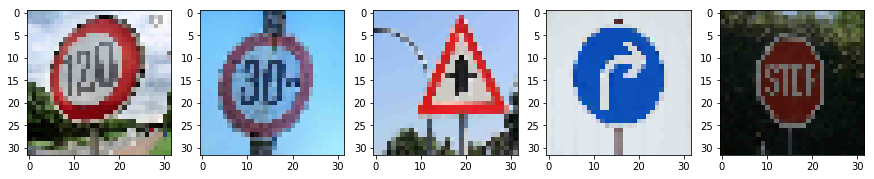

In [20]:
plt.figure(figsize=(15, 16))
for i in range(len(my_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(my_images[i])
plt.show()
my_labels=[8,1,11,33,14]

### Predict the Sign Type for Each Image

In [21]:
# New test data preprocessing
my_images_preprocessed = preprocess(np.asarray(my_images))

### Analyze Performance

In [22]:
def get_predictions(Input_data):
    pred = np.zeros((5, 5), dtype=np.int32)
    prob = np.zeros((5, 5))
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        prob, pred = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return prob, pred

INFO:tensorflow:Restoring parameters from ./lenet
My Images Test Accuracy = 60.0%


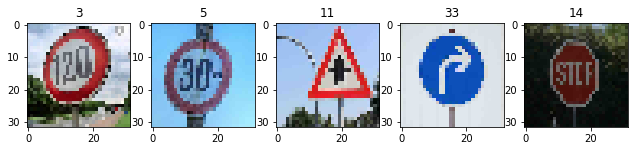

In [23]:
prob, pred = get_predictions(my_images_preprocessed)

test_accuracy = 0
for i in range(1,len(my_images_preprocessed)):
    accu = my_labels[i] == np.asarray(pred[i])[0]
    if accu == True:
        test_accuracy += 0.2
print("My Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(13, 15))
for i in range(len(my_images_preprocessed)):
    plt.subplot(1, 6, i+1)
    plt.imshow(my_images[i]) 
    plt.title(pred[i][0])
plt.show()

As one can see the accuracy is not very high. I choose these immages on purpose, since some of them are underrepresented in the test set. As one can see below the softmax probabilitie for f.e the turn right sign are really high since there are a lot of pictures of it in the training set. 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [26]:
def plot_prob():
    plt.figure(figsize=(13, 15))
    for i in range(len(my_images_preprocessed)):
        plt.subplot(5, 2, 2*i+2)
        plt.bar(np.arange(1, 6, 1), prob[i, :])
        labels = pred[i]
        plt.xticks(np.arange(1, 6, 1), labels)
    plt.show()

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [25]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")